CS4001/4042 Assignment 1
---
Part A, Q1 (15 marks)
---

>Design a feedforward deep neural network (DNN) which consists of **four** hidden layers with tapering width [256, 128, 64, 32] neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers and implement L2 weight decay with **weight_decay = 0.01**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import time
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

Define the model class.

In [2]:
from common_utils import MLP

model = MLP() # uses default input_dim of 57, hidden_sizes = [256,128,64,32]

> Divide the dataset into a 75:25 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

Split the dataset and do preprocessing. You can use the split_dataset and preprocess_dataset provided for you.

In [3]:
from common_utils import split_dataset, preprocess_dataset

df = pd.read_csv("C:\\Users\\ZW\\Desktop\\NN&DL assignment\\files_PartA\\files_PartA\\audio_gtzan.csv")

df['label'] = df['filename'].apply(lambda x: x.split('.')[0])

df = df.drop(columns=['filename'])

# drop the feature to be predicted AKA 'label'
columns_to_drop = ['label']

# Split dataset (75% train, 25% test)
X_train_df, y_train, X_test_df, y_test = split_dataset(
    df,                                            
    columns_to_drop=columns_to_drop,
    test_size=0.25,
    random_state=42
    ) 

X_train_scaled, X_test_scaled = preprocess_dataset(X_train_df, X_test_df)

> Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **'Adam'** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **5**.

1. Define a Pytorch Dataset and Dataloaders.  

In [4]:
from common_utils import AudioDataset

# Create datasets, AudioDataset function is changed slightly
train_ds = AudioDataset(X_train_scaled, y_train)
test_ds = AudioDataset(X_test_scaled, y_test)

# Create dataloaders
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

2. Next, define the model, optimizer and loss function.

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
loss_fn = nn.BCELoss()

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  
  model.train()
  train_loss, train_correct = 0,0
  for X,y in dataloader:
    
    # Compute prediction and loss
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()* X.size(0)
    
    pred_labels = (pred>0.5).float()
    train_correct += (pred_labels==y).sum().item()

  train_loss /= size
  train_correct /= size

  return train_loss, train_correct

def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  
  model.eval()
  test_loss, test_correct = 0,0

  with torch.no_grad():
    for X,y in dataloader:
      X = X.float()
      y = y.float().view(-1,1)
      
      pred = model(X)
      
      test_loss += loss_fn(pred, y).item() * X.size(0)
      
      pred_labels = (pred>0.5).float()
      test_correct += (pred_labels==y).sum().item()

  test_loss /= size
  test_correct /= size

  return test_loss, test_correct

In [7]:
from common_utils import EarlyStopper

early_stopper = EarlyStopper(patience=5, min_delta=0)

max_epochs = 100

tr_loss, tr_correct = [],[]
te_loss, te_correct = [],[]

for t in range(max_epochs):
  train_loss, train_correct = train_loop(train_loader, model, loss_fn, optimizer)
  test_loss, test_correct = test_loop(test_loader, model, loss_fn)

  tr_loss.append(train_loss), tr_correct.append(train_correct)
  te_loss.append(test_loss), te_correct.append(test_correct)

  print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

  if early_stopper.early_stop(test_loss):
    print("Done")
    break

Epoch 1: Train_accuracy: 59.00%, Train_loss: 0.679076, Test_accuracy: 79.60%, Test_loss: 0.650779
Epoch 2: Train_accuracy: 82.20%, Train_loss: 0.592991, Test_accuracy: 84.60%, Test_loss: 0.479331
Epoch 3: Train_accuracy: 87.33%, Train_loss: 0.387189, Test_accuracy: 89.80%, Test_loss: 0.268083
Epoch 4: Train_accuracy: 91.47%, Train_loss: 0.226325, Test_accuracy: 92.20%, Test_loss: 0.195761
Epoch 5: Train_accuracy: 94.80%, Train_loss: 0.142326, Test_accuracy: 93.80%, Test_loss: 0.164064
Epoch 6: Train_accuracy: 96.07%, Train_loss: 0.118893, Test_accuracy: 94.00%, Test_loss: 0.141477
Epoch 7: Train_accuracy: 96.87%, Train_loss: 0.098026, Test_accuracy: 95.20%, Test_loss: 0.114407
Epoch 8: Train_accuracy: 98.07%, Train_loss: 0.077244, Test_accuracy: 96.00%, Test_loss: 0.107234
Epoch 9: Train_accuracy: 98.20%, Train_loss: 0.068465, Test_accuracy: 96.00%, Test_loss: 0.093765
Epoch 10: Train_accuracy: 98.47%, Train_loss: 0.057525, Test_accuracy: 96.60%, Test_loss: 0.086473
Epoch 11: Train_acc

> Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.

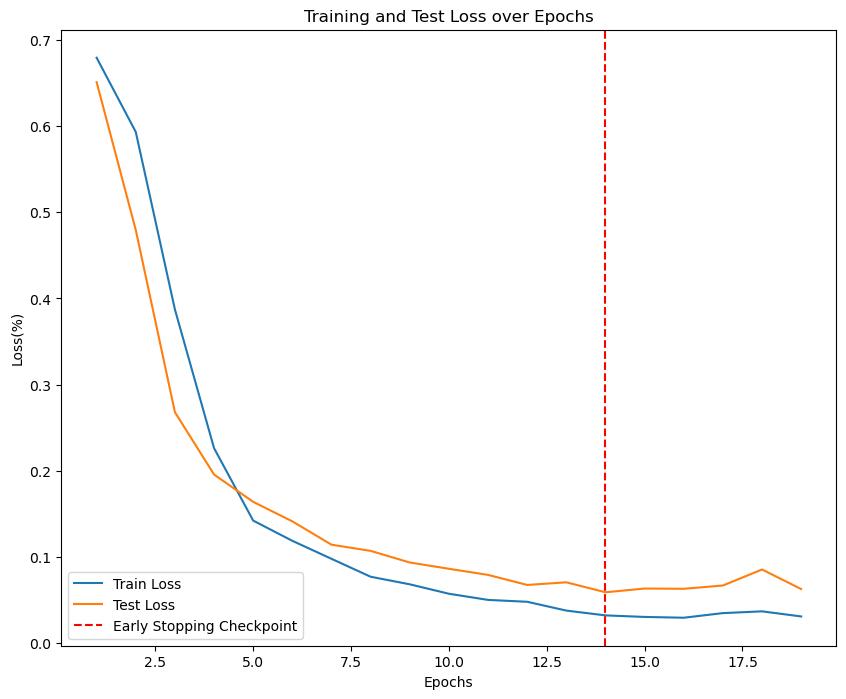

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(tr_loss)+1), tr_loss, label='Train Loss')
plt.plot(range(1, len(te_loss)+1), te_loss, label='Test Loss')

# find position of lowest validation loss
minposs = te_loss.index(min(te_loss))+1
plt.axvline(minposs, linestyle='--', color='r', label = 'Early Stopping Checkpoint')

plt.xlabel('Epochs')
plt.ylabel('Loss(%)')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.show()

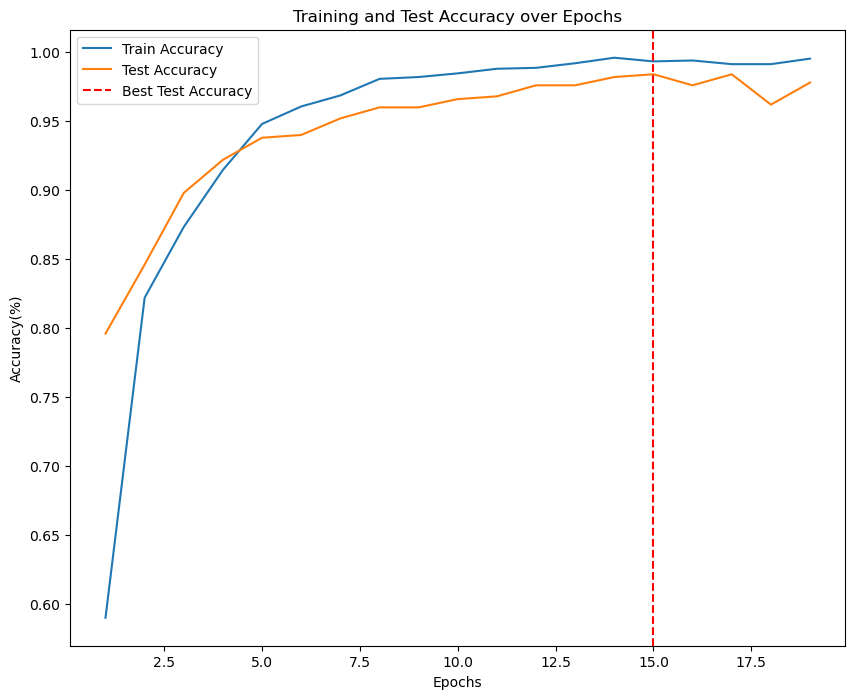

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(tr_correct)+1), tr_correct, label='Train Accuracy')
plt.plot(range(1, len(te_correct)+1), te_correct, label='Test Accuracy')

# find position of highest test accuracy
max_acc_pos = te_correct.index(max(te_correct))+1
plt.axvline(max_acc_pos, linestyle='--', color='r', label = 'Best Test Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.show()

#### Despite planning to train the model for 100 epochs, the early stopping mechanism reduced the time of model training with a checkpoint at epoch 14. The train loss is initially higher than the test loss but becomes lower than the test loss over future epochs. 

#### Initially, the dropout and weight decay causes the training predictions to be noisier and errors larger than evaluation. During testing, dropout is turned off with no weight decay so predictions are better.

#### Over epochs, the model improves its fit to the training set so train loss drops. Test loss also drops but plateau or rises due to overfitting. As the epoch iteration continues, the model memorises more training data and can better generalise to unseen test data.

#### Similarly, the train accuracy is initially lower than the test accuracy but becomes higher over future epochs. Over epochs, the model improves its training accuracy and test accuracy. The test accuracy may drop due to overfitting. As the epoch iteration continues, the model memorises more training data and can better generalise to unseen test data.


Part A, Q2 (10 marks)
---

In this question, we will determine the optimal learning rate for the Adam optimizer. Find the optimal learning rate by training the neural network and evaluating the performances for different learning rates. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

To reduce repeated code, you may need to place the network (MLP defined in QA1) in a separate file called **common_utils.py**. Import it here for Q2. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [3]:
from common_utils import MLP

X_train_scaled_dict = {}
X_val_scaled_dict = {}
y_train_dict = {}
y_val_dict = {}

>Plot mean cross-validation accuracies and mean cross-validation AUC scores on the final epoch for different learning rates as scatter plots. Limit search space to learning rates {0.0001, 0.0005, 0.001, 0.005, 0.01}. Keep batch_size fixed at 128. Create a table of time taken to train the network on the last epoch against different learning rates. Generate a confusion matrix for the optimal learning rate configuration. Finally, select the optimal learning rate and state a reason for your selection.

In [7]:
from sklearn.preprocessing import StandardScaler
from common_utils import split_dataset, preprocess_dataset
from common_utils import AudioDataset

df = pd.read_csv("C:\\Users\\ZW\\Desktop\\NN&DL assignment\\files_PartA\\files_PartA\\audio_gtzan.csv")

df['label'] = df['filename'].apply(lambda x: x.split('.')[0])

df = df.drop(columns=['filename'])
X = df.drop(columns=['label']).values
y = df['label'].map({'blues':0, 'metal':1}).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Hyperparameters
batch_size = 128
max_epochs = 100 # train per fold for this many epochs
lr_list = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
k_folds = 5

# Store final mean scores per learning rate
results = {}

for lr in lr_list:
    X_train_scaled_dict[lr] = []
    X_val_scaled_dict[lr] = []
    y_train_dict[lr] = []
    y_val_dict[lr] = []
    
    # Different folds per learning rate
    kf = KFold(n_splits = k_folds, shuffle=True, random_state=None)
    
    for train_idx, val_idx in kf.split(X_scaled):
        X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        # Preprocess (scaling)
        X_train_scaled, X_val_scaled = preprocess_dataset(
            pd.DataFrame(X_train_fold), pd.DataFrame(X_val_fold)
        )
        
        # Store in dicts
        X_train_scaled_dict[lr].append(X_train_scaled)
        X_val_scaled_dict[lr].append(X_val_scaled)
        y_train_dict[lr].append(y_train_fold)
        y_val_dict[lr].append(y_val_fold)

2. Perform hyperparameter tuning for the different learning rates with 5-fold cross validation.

In [8]:
from sklearn.metrics import accuracy_score, roc_auc_score
import time
import pandas as pd

# Dictionary to store fold times per LR
time_per_lr = {}

for lr in lr_list:
    fold_times = []
    acc_scores, auc_scores = [],[]
    
    for fold in range(k_folds):
        X_train_fold = X_train_scaled_dict[lr][fold]
        X_val_fold = X_val_scaled_dict[lr][fold]
        y_train_fold = y_train_dict[lr][fold]
        y_val_fold = y_val_dict[lr][fold]
        
        # Datasets and loaders
        train_ds = AudioDataset(X_train_fold, y_train_fold)
        val_ds = AudioDataset(X_val_fold, y_val_fold)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=batch_size)
        
        # Initialize model
        model = MLP()
        loss_fn = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
        
        start_time = time.time()
        
        # Training loop 
        for epoch in range(max_epochs):
            model.train()
            for Xb, yb in train_loader:
                Xb = Xb.float()
                yb = yb.float().view(-1,1) # shape [batch,-1]
                pred = model(Xb)
                loss = loss_fn(pred, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        end_time = time.time()
        fold_times.append(end_time-start_time)
                
        # Evaluate on validation set(final epoch)
        model.eval()
        y_true, y_pred, y_prob = [],[],[]
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb = Xb.float()
                yb = yb.float().view(-1,1) # shape [batch,-1]
                out = model(Xb)
                probs = out.cpu().numpy().flatten()
                preds = (probs > 0.5).astype(int)
                y_true.extend(yb.numpy().flatten())
                y_pred.extend(preds)
                y_prob.extend(probs)
                
        acc_scores.append(accuracy_score(y_true, y_pred))
        try:
            auc_scores.append(roc_auc_score(y_true, y_prob))
        except ValueError:
            auc_scores.append(np.nan)
    
    time_per_lr[lr] = np.mean(fold_times)        
            
    # Store mean scores for this learning rate
    results[lr] = {
        "mean_acc": np.nanmean(acc_scores),
        "mean_auc":np.nanmean(auc_scores)
    }
            

3. Plot scatterplot of mean cross validation accuracies and AUC scores on the final epoch for the different learning rates. Limit search space to learning rates {0.0001, 0.0005, 0.001, 0.005, 0.01}.

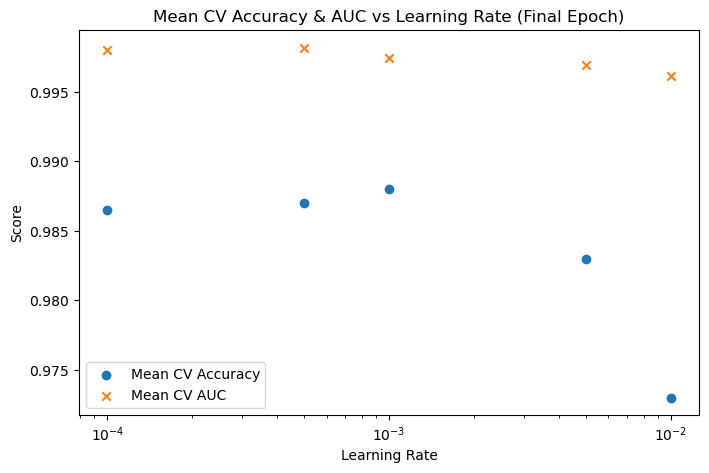

In [11]:
lrs = list(results.keys())
mean_accs = [results[lr]["mean_acc"] for lr in lrs]
mean_aucs = [results[lr]["mean_auc"] for lr in lrs]

plt.figure(figsize=(8,5))
plt.scatter(lrs, mean_accs, marker='o', label="Mean CV Accuracy")
plt.scatter(lrs, mean_aucs, marker='x', label="Mean CV AUC")
plt.xscale("log")
plt.xlabel("Learning Rate")
plt.ylabel("Score")
plt.title("Mean CV Accuracy & AUC vs Learning Rate (Final Epoch)")
plt.legend()
plt.show()

4. Create a table of time taken to train the network on the last epoch against different learning rates. Generate a confusion matrix for the optimal learning rate configuration.

In [12]:
time_table = pd.DataFrame({
    "Learning Rate": list(time_per_lr.keys()),
    "Avg Time Last Epoch (s)": list(time_per_lr.values())
})

print(time_table)

   Learning Rate  Avg Time Last Epoch (s)
0         0.0001                 3.301548
1         0.0005                 3.239079
2         0.0010                 3.343786
3         0.0050                 3.307843
4         0.0100                 3.144854


5. Select the optimal learning rate and state a reason for your selection.

#### Based on the results, a learning rate of 0.001 is chosen as it has the highest mean cross validation accuracy. The cross validation accuracy highlights how often the model is right.

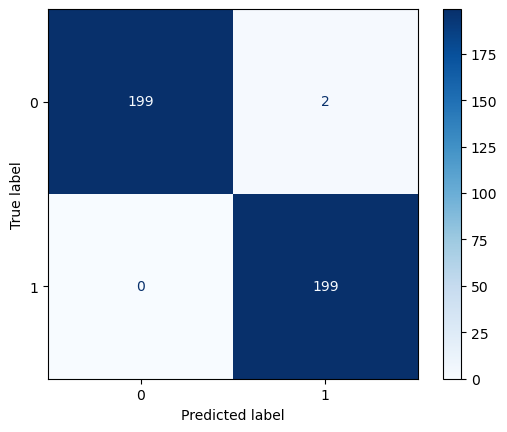

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Use the chosen best learning rate
best_lr = 0.001

X_train_full = X_scaled
y_train_full = y

train_ds = AudioDataset(X_train_full, y_train_full)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# Validation/Test set
X_test = X_val_scaled_dict[best_lr][0]
y_test = y_val_dict[best_lr][0]

test_ds = AudioDataset(X_test, y_test)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# Train the model
model = MLP()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=best_lr,weight_decay=0.01)

for epoch in range(max_epochs):
    model.train()
    for Xb, yb in train_loader:
        Xb = Xb.float()
        yb = yb.float().view(-1,1) # shape [batch,-1]
        pred = model(Xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
# Evaluate on validation set(final epoch)
model.eval()
y_true, y_pred = [],[]
with torch.no_grad():
    for Xb, yb in val_loader:
        Xb = Xb.float()
        yb = yb.float().view(-1,1) # shape [batch,-1]
        out = model(Xb)
        probs = out.cpu().numpy().flatten()
        preds = (probs > 0.5).astype(int)
        y_true.extend(yb.numpy().flatten())
        y_pred.extend(preds)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()

Part A, Q3 (10 marks)
---
In this question, we will find the optimal number of hidden neurons for first hidden layer of the 5-layer network (4 hidden layers, output layer) designed in Q1 and Q2.

To reduce repeated code, you may need to import the network (MLP defined in QA1) from common_utils.py. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from common_utils import split_dataset, preprocess_dataset,AudioDataset
from sklearn.model_selection import KFold

> Plot the mean cross-validation accuracies on the final epoch for different numbers of first hidden-layer neurons using a scatter plot. Maintain the tapering pattern (e.g., if first layer is 256, use [256, 128, 64, 32]). Limit the search space of the first layer neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. Add ROC curve plotting for the final selected architecture.

1. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [17]:
df = pd.read_csv("C:\\Users\\ZW\\Desktop\\NN&DL assignment\\files_PartA\\files_PartA\\audio_gtzan.csv")

df['label'] = df['filename'].apply(lambda x: x.split('.')[0])

df = df.drop(columns=['filename'])
X = df.drop(columns=['label']).values
y = df['label'].map({'blues':0, 'metal':1}).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Hyperparameters
batch_size = 128
max_epochs = 100 # train per fold for this many epochs
hidden_sizes_list = [64,128,256]
k_folds = 5

# Store final mean scores per learning rate
results = {}

X_train_scaled_folds = []
X_val_scaled_folds = []
y_train_folds = []
y_val_folds = []

# Different folds per learning rate
kf = KFold(n_splits = k_folds, shuffle=True, random_state=None)

for train_idx, val_idx in kf.split(X_scaled):
    X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]
    
    # Preprocess (scaling)
    X_train_scaled, X_val_scaled = preprocess_dataset(
        pd.DataFrame(X_train_fold), pd.DataFrame(X_val_fold)
    )
    
    # Store in dicts
    X_train_scaled_folds.append(X_train_scaled)
    X_val_scaled_folds.append(X_val_scaled)
    y_train_folds.append(y_train_fold)
    y_val_folds.append(y_val_fold)

2. Plot the mean cross-validation accuracies on the final epoch for different numbers of first hidden-layer neurons using a scatter plot. Limit the search space of the first layer neurons to {64, 128, 256}.

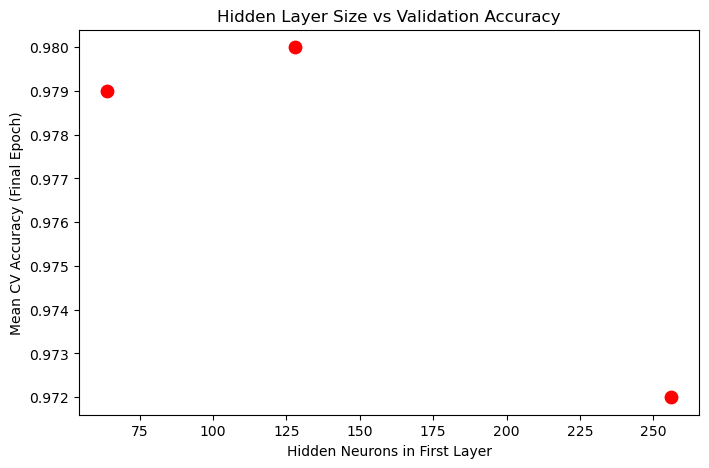

In [22]:
for h1 in hidden_sizes_list:
    # Define the tapering pattern
    hidden_pattern = [h1, h1//2, h1//4, h1//8]
    
    acc_scores = []
    
    for fold in range(k_folds):
        X_train_fold = X_train_scaled_folds[fold]
        X_val_fold = X_val_scaled_folds[fold]
        y_train_fold = y_train_folds[fold]
        y_val_fold = y_val_folds[fold]
        
        # Datasets and loaders
        train_ds = AudioDataset(X_train_fold, y_train_fold)
        val_ds = AudioDataset(X_val_fold, y_val_fold)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=batch_size)
        
        # Initialize model
        model = MLP(hidden_sizes=hidden_pattern)
        loss_fn = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
                
        # Training loop 
        for epoch in range(max_epochs):
            model.train()
            for Xb, yb in train_loader:
                Xb = Xb.float()
                yb = yb.float().view(-1,1) # shape [batch,-1]
                pred = model(Xb)
                loss = loss_fn(pred, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        # Evaluate on validation set(final epoch)
        model.eval()
        y_true, y_pred= [],[]
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb = Xb.float()
                #yb = yb.float().view(-1,1) # shape [batch,-1]
                out = model(Xb)
                probs = out.cpu().numpy().flatten()
                preds = (probs > 0.5).astype(int)
                y_true.extend(yb.numpy().flatten())
                y_pred.extend(preds)
                
        acc_scores.append(accuracy_score(y_true, y_pred))
                
    # Store mean scores for this learning rate
    results[h1] = np.mean(acc_scores)
    
# Scatter plot
hidden_lyr_size =list(results.keys())
mean_accs = list(results.values())

plt.figure(figsize=(8,5))
plt.scatter(hidden_lyr_size, mean_accs, marker='o', color="red", s=80)
plt.xlabel("Hidden Neurons in First Layer")
plt.ylabel("Mean CV Accuracy (Final Epoch)")
plt.title("Hidden Layer Size vs Validation Accuracy")
plt.show()
            

> Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

#### The optimal number of neurons for the first hidden layer is 128 with tapering pattern as it has the highest mean CV accuracy amongst the number of neurons in the search space. 

> Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot. Add ROC curve plotting for the final selected architecture.
Note: use this optimal number of neurons for the rest of the experiments.

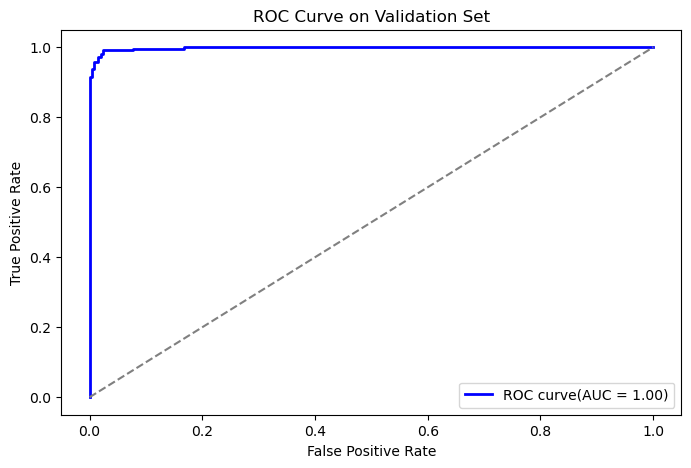

In [10]:
from sklearn.metrics import roc_curve, auc
import pandas as pd
from common_utils import split_dataset, AudioDataset, MLP
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader
from torch import nn

df = pd.read_csv("C:\\Users\\ZW\\Desktop\\NN&DL assignment\\files_PartA\\files_PartA\\audio_gtzan.csv")

df['label'] = df['filename'].apply(lambda x: x.split('.')[0])

df['label'] = df['label'].map({'blues':0, 'metal':1}).values

df = df.drop(columns=['filename'])

# drop the feature to be predicted AKA 'label'
columns_to_drop = ['label']

# Split dataset (75% train, 25% test)
X_train_df, y_train, X_val_df, y_val = split_dataset(
    df,                                            
    columns_to_drop=columns_to_drop,
    test_size=0.25,
    random_state=42
    ) 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_val_scaled = scaler.fit_transform(X_val_df)

# Define the best tapering pattern
hidden_pattern = [128,64,32,16]

# Hyperparameters
batch_size = 128
max_epochs = 100
lr = 0.001 

acc_scores = []

# Datasets and loaders
train_ds = AudioDataset(X_train_scaled, y_train)
val_ds = AudioDataset(X_val_scaled, y_val)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
    
# Initialize model
model = MLP(hidden_sizes=hidden_pattern)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)

# Train for full epochs while recording train accuracy
train_accs = []
val_accs = []
            
# Training loop 
for epoch in range(max_epochs):
    model.train()
    correct_train = 0
    total_train = 0
    for Xb, yb in train_loader:
        Xb = Xb.float()
        yb = yb.float().view(-1,1) # shape [batch,-1]
        pred = model(Xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Training accuracy
        correct_train += ((pred>0.5).int() == yb.int()).sum().item()
        total_train += yb.size(0)
        
    train_accs.append(correct_train/total_train)
    
    # Evaluate on validation set(final epoch)
    model.eval()
    correct_val = 0
    total_val = 0
    y_true, y_prob= [],[]
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb = Xb.float()
            yb = yb.float().view(-1,1) # shape [batch,-1]
            out = model(Xb)
            probs = out.cpu().numpy().flatten()
            y_true.extend(yb.numpy().flatten())
            y_prob.extend(probs)
            correct_val += ((out>0.5).int()==yb.int()).sum().item()
            total_val += yb.size(0)
            
    val_accs.append(correct_val/total_val)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)            

plt.figure(figsize=(8,5))
plt.plot(fpr,tpr, color='blue',lw=2, label=f'ROC curve(AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Validation Set")
plt.legend(loc='lower right')
plt.show()            

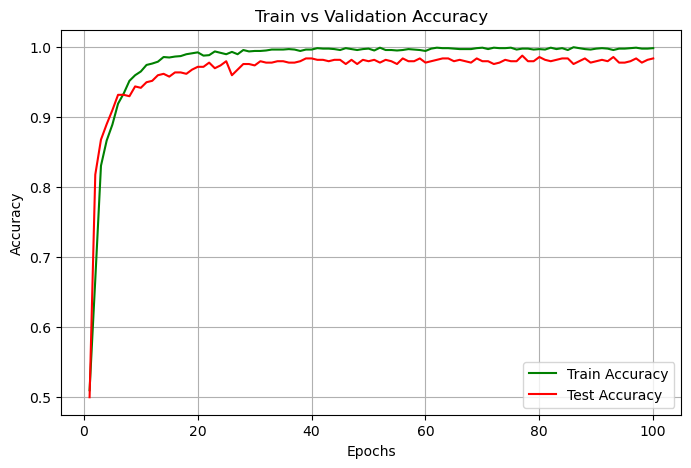

In [11]:
plt.figure(figsize=(8,5))
plt.plot(range(1, max_epochs+1), train_accs, label='Train Accuracy', color='green')
plt.plot(range(1, max_epochs+1), val_accs, label='Test Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

Part A, Q4 (10 marks)
---
In this section, we will understand the utility of such a neural network for a test audio. 

Please use the 'audio_test.wav' as a test sample. Preprocess the data using the function 'extract_features' in common_utils.py. 
Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal learning rate and optimal number of neurons. 
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations. 
Identify the top 5 most influential features (both positive and negative) and explain why these features make sense for music genre classification (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

Identify the top 5 most influential features (both positive and negative) and explain why these features make sense for music genre classification.


To reduce repeated code, you may need to import the network (MLP defined in QA1) from **common_utils.py**. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

> Install and import shap

In [ ]:
%pip install shap

   ---------------------------------------- 0.0/544.4 kB ? eta -:--:--
   ---------------------------------------- 544.4/544.4 kB 18.8 MB/s  0:00:00

   -------------------- ------------------- 1/2 [shap]
   ---------------------------------------- 2/2 [shap]

Note: you may need to restart the kernel to use updated packages.


> Preprocess 'audio_test.wav' in the folder 'audio' using the function 'extract_features' in common_utils.py. Use a pandas dataframe to store the features, using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [ ]:
#import IPython
#IPython.display.Audio("./audio_test.wav")

In [1]:
from common_utils import extract_features
import shap

df = extract_features("C:\\Users\\ZW\\Desktop\\NN&DL assignment\\files_PartA\\files_PartA\\audio_test.wav")
size_row = len(df)
size_column = len(df.columns)

print("Rows: ", size_row)
print("Columns: ", size_column)

c:\Users\ZW\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


Rows:  1
Columns:  58


> Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal learning rate and optimal number of neurons. 

 1.  Preprocess to obtain the test data, save the test data as numpy array, print the shape of the test data.

In [2]:
# TODO: Enter your code here
# Before doing 1. Train the model with the optimal learning rate and number of neurons

import pandas as pd
from common_utils import split_dataset, AudioDataset, MLP
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader
from torch import nn

scaler = StandardScaler()

full_df = pd.read_csv("C:\\Users\\ZW\\Desktop\\NN&DL assignment\\files_PartA\\files_PartA\\audio_gtzan.csv")
full_df['label'] = full_df['filename'].apply(lambda x: x.split('.')[0])
full_df['label'] = full_df['label'].map({'blues':0, 'metal':1}).values
full_df = full_df.drop(columns=['filename'])

# drop the feature to be predicted AKA 'label'
columns_to_drop = ['label']

# Split dataset (75% train, 25% test)
X_train_df, y_train, X_val_df, y_val = split_dataset(
    full_df,                                            
    columns_to_drop=columns_to_drop,
    test_size=0.25,
    random_state=42
    ) 

X_train_scaled = scaler.fit_transform(X_train_df)

# Define the best tapering pattern
hidden_pattern = [128,64,32,16]

# Hyperparameters
batch_size = 128
max_epochs = 100
lr = 0.001 

# Datasets and loaders
train_ds = AudioDataset(X_train_scaled, y_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    
# Initialize model
model = MLP(hidden_sizes=hidden_pattern)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
            
# Training loop 
for epoch in range(max_epochs):
    model.train()
    for Xb, yb in train_loader:
        Xb = Xb.float()
        yb = yb.float().view(-1,1) # shape [batch,-1]
        pred = model(Xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
df['label'] = df['filename'].apply(lambda x: x.split('.')[0])
df['label'] = df['label'].map({'blues':0, 'metal':1}).values
df = df.drop(columns=['filename'])

df_scaled = scaler.transform(df.drop(columns=['label']))
X_sample = torch.tensor(df_scaled, dtype=torch.float32)    
    
model.eval()
with torch.no_grad():
    output = model(X_sample)
    prob = output.item()
    pred_label = 1 if prob >0.5 else 0

print(f"Predicted label: {pred_label}, probability={prob:.4f}")



Predicted label: 0, probability=0.0372


2. Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal learning rate and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [3]:
print(pred_label)

0


#### The model has predicted the sample audio file as `blues` as 0 was meant to signify blues and 1 was meant to signify metal.

> Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 


Identify the top 5 most influential features (both positive and negative) and explain why these features make sense for music genre classification.


In [4]:
df_scaled.dtype

dtype('float64')

In [7]:
'''
Fit the explainer on a subset of the data (you can try all but then gets slower)
Return approximate SHAP values for the model applied to the data given by X.
Plot the local feature importance with a force plot and explain your observations.
'''
# pick a background dataset for SHAP
background = X_train_scaled[:100]

X_sample_np = df_scaled

# use DeepExplainer
explainer = shap.DeepExplainer(model, torch.tensor(background,dtype=torch.float32))
shap_values = explainer.shap_values(torch.tensor(X_sample_np, dtype=torch.float32))
shap_values = shap_values[0]
shap_values = shap_values.reshape(1,-1)

In [8]:
print("shap_values.shape:", shap_values.shape)
print("X_sample_np.shape:", X_sample_np.shape)

shap_values.shape: (1, 57)
X_sample_np.shape: (1, 57)


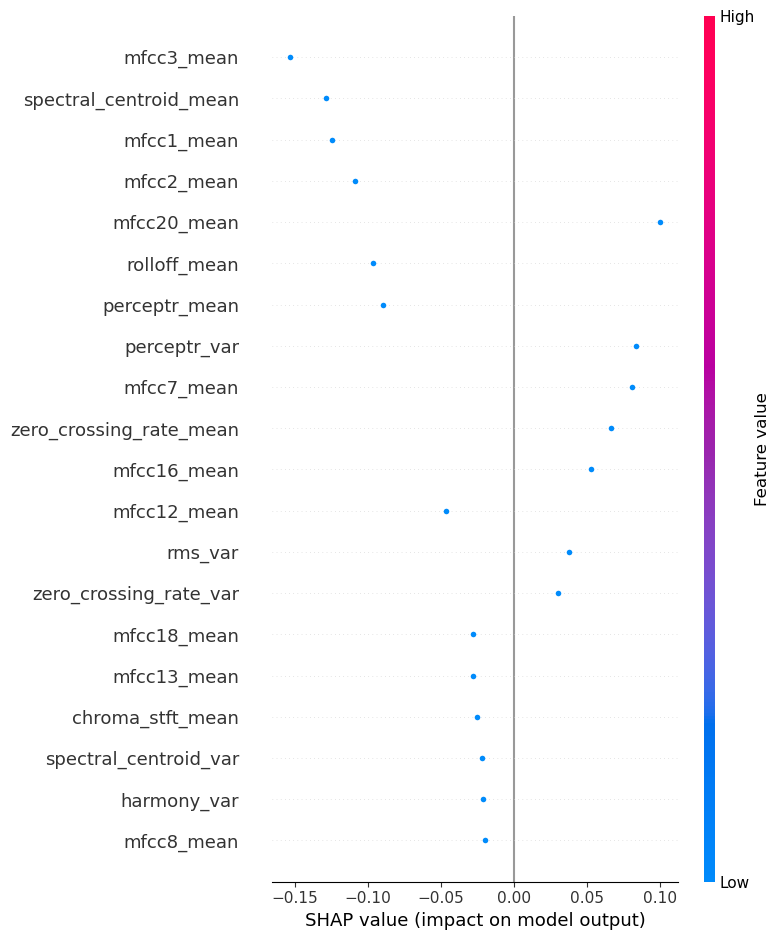

In [9]:
# Summary plot
feature_names = df.drop(columns=['label']).columns
shap.summary_plot(shap_values, features=X_sample_np, feature_names=feature_names)

In [11]:
shap.initjs()

shap.force_plot(
    explainer.expected_value[0],
    shap_values[0],
    features=X_sample_np[0],
    feature_names=feature_names
)

#### The top 5 most influential (both positive and negative) features (in descending order) are:
- 1. mfcc3_mean
- 2. spectral_centroid_mean
- 3. mfcc1_mean
- 4. mfcc2_mean
- 5. mfcc20_mean

#### mfcc3_mean ccaptures mid level variation in timbre which helps in distinguishing the genres of `metal` and `blues.
#### spectral_centroid_mean captures where most of the energy is in frequency. `Metal` songs have higher spectral centroid than `blues` so it is a good feature for differentiation.
#### mfcc1_mean represents the overall spectral shape, helps the model to quickly separate genres with different general tonal qualities.
#### mfcc2_mean adds finer detail about spectral shape, complements mfcc1_mean  to provide more information on tonal contour differences.
#### mfcc20_mean captures very fine grained spectral details and help differentiate genres with complex high frequency content through subtle texture differences.